In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, losses, models

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 6GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

1 Physical GPUs, 1 Logical GPUs


In [3]:
from sklearn.model_selection import train_test_split

def get_data(data_path,label_path):
    
    data_list = os.listdir(data_path)
    label_list = os.listdir(label_path)
#     num = min(len(data_list),len(label_list))
    num = 2500
    
    X_all = []
    y_all = []

    for i in range(num):
        print("Processing: ",i+1,"/",num)
        clear_output(wait=True)

        img = cv2.imdecode(np.fromfile(data_path+data_list[i], dtype=np.uint8), cv2.IMREAD_COLOR)
        label = cv2.imdecode(np.fromfile(label_path+label_list[i], dtype=np.uint8), cv2.IMREAD_GRAYSCALE)      
#         img = cv2.imread(data_path+data_list[i],cv2.IMREAD_COLOR)
#         label = cv2.imread(label_path+label_list[i],cv2.IMREAD_GRAYSCALE)

        X_all.append(img)
        y_all.append(label)
        
    print("Spliting..")
    clear_output(wait=True)

    X_all = np.array(X_all)/255
    y_all = np.array(y_all)/255
    
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=1234)
    
    print("Done!")
    
    return X_train, X_test, y_train, y_test

In [4]:
data_path = './data_processed/unet_data/'
label_path = './data_processed/unet_label/'

X_train, X_test, y_train, y_test = get_data(data_path,label_path)

Done!


In [5]:
def get_unet(h,w):
    
    def Conv2d_BN(x, nb_filter, kernel_size, strides=(1, 1), padding='same'):
        x = layers.Conv2D(nb_filter, kernel_size, strides=strides, padding=padding)(x)
        x = layers.BatchNormalization(axis=3)(x)
        x = layers.LeakyReLU(alpha=0.1)(x)
        return x
 
    def Conv2dT_BN(x, filters, kernel_size, strides=(2, 2), padding='same'):
        x = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)(x)
        x = layers.BatchNormalization(axis=3)(x)
        x = layers.LeakyReLU(alpha=0.1)(x)
        return x
 
    inpt = layers.Input(shape=(h, w, 3))
    conv1 = Conv2d_BN(inpt, 8, (3, 3))
    conv1 = Conv2d_BN(conv1, 8, (3, 3))
    pool1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conv1)
 
    conv2 = Conv2d_BN(pool1, 16, (3, 3))
    conv2 = Conv2d_BN(conv2, 16, (3, 3))
    pool2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conv2)
 
    conv3 = Conv2d_BN(pool2, 32, (3, 3))
    conv3 = Conv2d_BN(conv3, 32, (3, 3))
    pool3 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conv3)
 
    conv4 = Conv2d_BN(pool3, 64, (3, 3))
    conv4 = Conv2d_BN(conv4, 64, (3, 3))
    pool4 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conv4)
 
    conv5 = Conv2d_BN(pool4, 128, (3, 3))
    conv5 = layers.Dropout(0.5)(conv5)
    conv5 = Conv2d_BN(conv5, 128, (3, 3))
    conv5 = layers.Dropout(0.5)(conv5)
 
    convt1 = Conv2dT_BN(conv5, 64, (3, 3))
    concat1 = layers.concatenate([conv4, convt1], axis=3)
    concat1 = layers.Dropout(0.5)(concat1)
    conv6 = Conv2d_BN(concat1, 64, (3, 3))
    conv6 = Conv2d_BN(conv6, 64, (3, 3))
 
    convt2 = Conv2dT_BN(conv6, 32, (3, 3))
    concat2 = layers.concatenate([conv3, convt2], axis=3)
    concat2 = layers.Dropout(0.5)(concat2)
    conv7 = Conv2d_BN(concat2, 32, (3, 3))
    conv7 = Conv2d_BN(conv7, 32, (3, 3))
 
    convt3 = Conv2dT_BN(conv7, 16, (3, 3))
    concat3 = layers.concatenate([conv2, convt3], axis=3)
    concat3 = layers.Dropout(0.5)(concat3)
    conv8 = Conv2d_BN(concat3, 16, (3, 3))
    conv8 = Conv2d_BN(conv8, 16, (3, 3))
 
    convt4 = Conv2dT_BN(conv8, 8, (3, 3))
    concat4 = layers.concatenate([conv1, convt4], axis=3)
    concat4 = layers.Dropout(0.5)(concat4)
    conv9 = Conv2d_BN(concat4, 8, (3, 3))
    conv9 = Conv2d_BN(conv9, 8, (3, 3))
    conv9 = layers.Dropout(0.5)(conv9)
    outpt = layers.Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(conv9)
 
    model = models.Model(inpt, outpt)
    
    return model

In [6]:
tf.keras.backend.clear_session()
unet = get_unet(512,512)
# unet.summary()

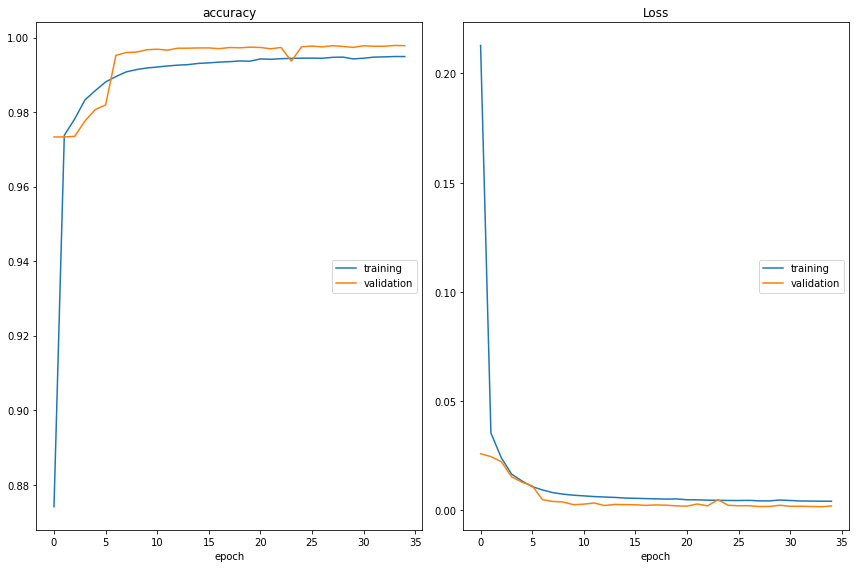

accuracy
	training         	 (min:    0.874, max:    0.995, cur:    0.995)
	validation       	 (min:    0.973, max:    0.998, cur:    0.998)
Loss
	training         	 (min:    0.004, max:    0.213, cur:    0.004)
	validation       	 (min:    0.002, max:    0.026, cur:    0.002)


In [7]:
from livelossplot import PlotLossesKerasTF
plotlosses = PlotLossesKerasTF()

tf.keras.backend.clear_session()
unet = get_unet(512,512)

unet.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

# callbacks = [tf.keras.callbacks.ModelCheckpoint("Unet_Segmentation.h5", save_best_only=True)]

unet.fit(X_train, y_train, epochs=35, batch_size=16, validation_data=(X_test, y_test),callbacks=[plotlosses])

In [8]:
# unet.save('unet.h5')

loss, accuracy = unet.evaluate(X_test, y_test,batch_size=16)
print('\ntest loss: ', loss)
print('\ntest accuracy: ', accuracy)

47/47 [==============================] - 2s 50ms/step - loss: 0.0021 - accuracy: 0.9978

test loss:  0.0020592843648046255

test accuracy:  0.9978303909301758
